In [ ]:
# default_exp loaders

# Datasets, DataLoaders, Samplers

In [1]:
# export

import random
import numpy as np
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A

In [2]:
from lunglens.data import *

### Basic dataset

Generates specified number of slices from one scans per one item. Length of the dataset is equal to the number of scans

In [3]:
# export

default_dict = {
    'slices_per_scan': 4,
    'inter_slice_distance': 40
}

class RandomSlicerDataset(Dataset):
    def __init__(self, datasets_root, transform=None, config=default_dict):
        self.scans = list(datasets_root.glob('*/*'))
        self.config = config
        self.transform = transform
        self.slices_cache = {}

    def __len__(self):
        return len(self.scans)

    def __getitem__(self, idx):
        # idx can be an indexing slice or an index
        if isinstance(idx, slice):
            idx_range = range(len(self))[idx]
            
            return [self.get_item(idx) for idx in idx_range]
        else:
            return self.get_item(idx)
    
    def get_item(self, idx):
        scan_dir = self.scans[idx]

        if str(scan_dir) not in self.slices_cache:
            self.slices_cache[scan_dir] = list(scan_dir.glob('*.npy'))

        # retrun slices according to config
        # TBD confirm that the slices are indeed ordered (!!!)
        idx_first_slice = np.random.randint(len(self.slices_cache[scan_dir]) - \
                                            self.config['inter_slice_distance'] * (self.config['slices_per_scan'] - 1))
        idx_list = idx_first_slice + self.config['inter_slice_distance'] * np.arange(self.config['slices_per_scan'])
        random_slices = [self.slices_cache[scan_dir][idx] for idx in idx_list]
        #print(random_slices)
        #random_slices = random.sample(
        #    self.slices_cache[scan_dir],
        #    self.config['slices_per_scan'])

        aug_slices = [self.load_slice(s) for s in random_slices]
        s0 = np.stack([s[0] for s in aug_slices])
        s1 = np.stack([s[1] for s in aug_slices])
        #print(len(aug_slices), len(aug_slices[0]))
        return s0, s1
        #return np.stack([self.load_slice(s) for s in random_slices])
    
    def load_slice(self, path):
        # load one slice of the scan
        s = np.load(str(path))
        #print(self.transform)
        
        s0 = self.transform(image=s)['image'] if self.transform else s
        s1 = self.transform(image=s)['image'] if self.transform else s
        return s0, s1
        #return self.transform(image=s)['image'] if self.transform else s

In [4]:
datasets_root = Path('../data/prepared')
#datasets_root = Path('../data/prepared/osic-pulmonary-fibrosis-progression')
dataset = RandomSlicerDataset(datasets_root)
len(dataset)

175

In [5]:
# this just an example
tfms = A.Compose([
    A.Resize(512, 512),
    A.RandomCrop(384, 384)
], p=1)

In [6]:
#datasets_root = Path('../data/prepared')
dataset = RandomSlicerDataset(datasets_root, transform=tfms)
len(dataset)

175

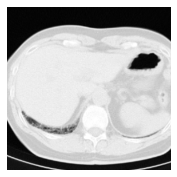

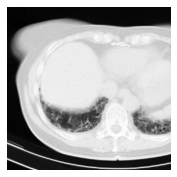

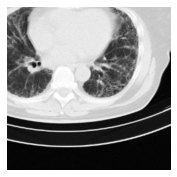

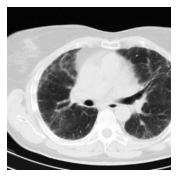

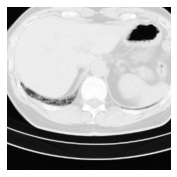

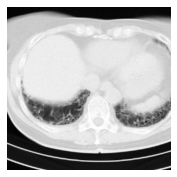

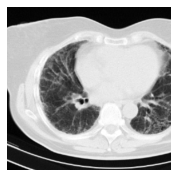

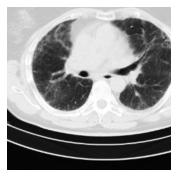

In [7]:
#print_slice(random.choice(random.choice(dataset)))
for slice_images in random.choice(dataset):
    for slice_img in slice_images:
        print_slice(slice_img, figsize=(3, 3))


#### Checking if caching is working
Enumerating the dicrectory is cached but slices loading is not because datasets are too big

In [8]:
%%time
for slices_batch in dataset[:10]:
    pass

Wall time: 350 ms


In [9]:
%%time
for slices_batch in dataset[:10]:
    pass

Wall time: 319 ms


#### Testing with default dataloader

In [10]:
batch_size = 8

loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

#### Optionally we can squash per-scan batches into one batch

In [11]:
# export

def squash_scan_batches(superbatch):
    shape = list(superbatch.shape)
    
    # slices from all scans and all batches go to single batch
    shape[1] = shape[1] * shape[0]
    shape[0] = 1
    
    return superbatch.view(*shape)


In [12]:
squash_scans = True

In [13]:
for superbatch0, superbatch1 in loader:
    break

In [14]:
type(superbatch0), superbatch0.shape

(torch.Tensor, torch.Size([8, 4, 384, 384]))

In [15]:
if squash_scans:
    shape = list(superbatch0.shape)
    reshaped_batch0 = squash_scan_batches(superbatch0)
    reshaped_batch1 = squash_scan_batches(superbatch1)
    print(reshaped_batch0.shape)

torch.Size([1, 32, 384, 384])


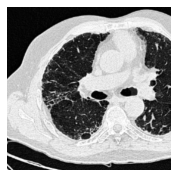

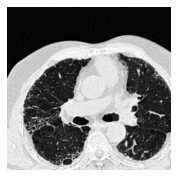

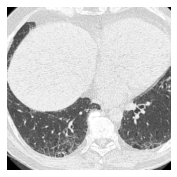

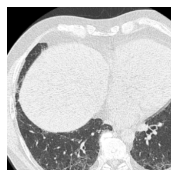

In [16]:
print_slice(superbatch0[0][1], figsize=(3, 3))
print_slice(superbatch1[0][1], figsize=(3, 3))
print_slice(superbatch0[1][1], figsize=(3, 3))
print_slice(superbatch1[1][1], figsize=(3, 3))

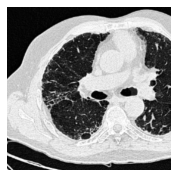

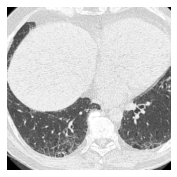

In [17]:
print_slice(reshaped_batch0[0][1], figsize=(3, 3))
print_slice(reshaped_batch0[0][4 + 1], figsize=(3, 3))